# Machine Learning - Aufgabenblatt 5

## Datensatz

Wir benutzen den "Fashion-MNIST" Datensatz. Dieser Datensatz wurde von Zalando erstellt und publiziert und enthält verschiedene Kleidungsstücke und Accessoires aus der Modewelt. Die Bilder sind absichtlich klein (28x28 Pixel) und in Schwarz-Weiss. Damit sollten Machine Learning Algorithmen getestet werden können.

## Ziel

Unser Ziel ist es den Datensatz zu analysieren. Insbesondere:

1. Gibt es Strukturen in den Daten? Kann man die Daten deshalb gut komprimieren?
2. Gibt es Gruppen / Klassen in den Daten?


![Ziel des Aufgabenblattes](./img/goal.png)

## Setup

Im Folgenden laden wir die wichtigsten Module und definieren einige Hilfs-Funktionen.

In [16]:
import os
import gzip

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans


In [2]:
def plot_image_grid(images, N=10, image_size=(28,28), random=False, title=''):
    ''' Utility plotting function to display NxN images on a grid.
    
    Reshaping of image vector into 2d-array of size image_size.
    '''

    assert np.ndim(images) == 2, "images need to be in shape (NxK)"
    
    fig, axs = plt.subplots(N,N, figsize=(15,15))
    idxs = np.arange(0,images.shape[0])
    if random:
        idxs = np.random.permutation(idxs)
    for idx, ax in enumerate(axs.flatten()):
        ax.imshow(
            images[idxs[idx]].reshape(image_size[0], image_size[1]),
            interpolation='none',
            cmap='gray_r'
        )
        # do not show the axis ticks
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

    if len(title) > 0:
        st = fig.suptitle(title, fontsize=14)
        fig.tight_layout()
        st.set_y(0.95)
        fig.subplots_adjust(top=0.93)


def load_fashion_mnist(path, kind='train'):
    """Load Fashion MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Wir laden nun die Daten.

In [3]:
X, y = load_fashion_mnist('./data/fashion_mnist/', kind='t10k')

## Aufgabe 1 - Daten-Analyse / Übersicht

Die erste Aufgabe besteht darin, ein Sample der Daten zu visualisieren. 

1. Benutzen Sie die Funktion `plot_image_grid()` und plotten Sie die 100 ersten Bilder.
2. Wieviele Bilder sind im Datensatz?
3. Können Sie anhand der Beispiele schon abschätzen wieviele "Klassen" es im Datensatz gibt?

Number of images:  (10000, 784)


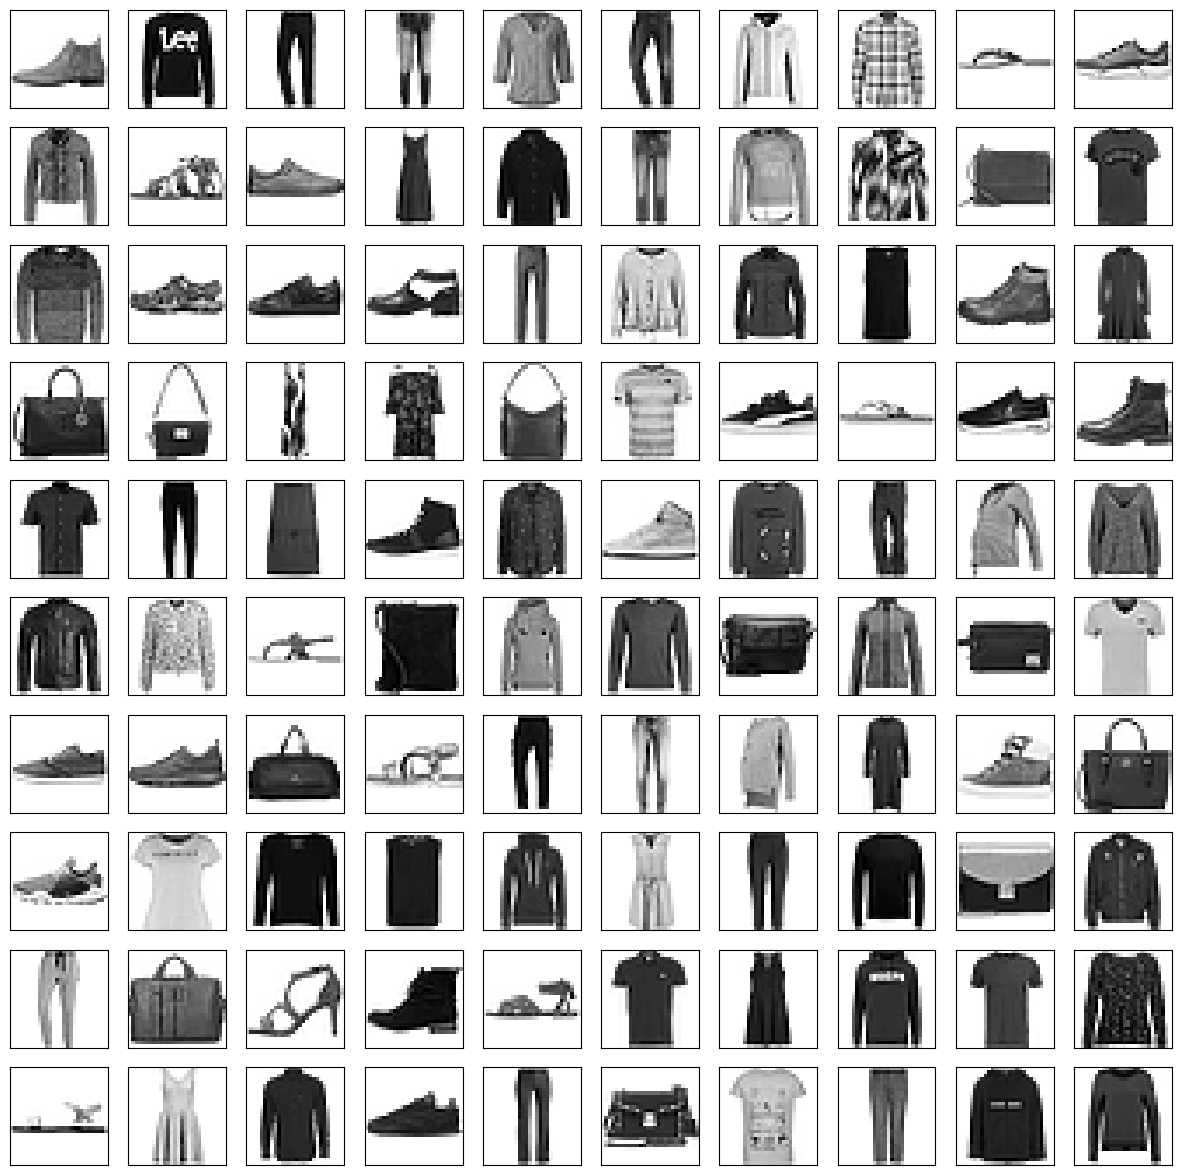

In [11]:
# TODO
plot_image_grid(X[:100])

print('Number of images: ', X.shape[0])

## Aufgabe 2) - Principal Component Analysis

Als nächstes zerlegen wir die Daten-Matrix mit PCA und analysieren die Resultate. Die folgenden Schritte sollen durchgeführt werden:

1. Die Daten sollen zentriert und standardisiert werden. Wir verwenden dazu den `sklearn.preprocessing.StandardScaler()`
2. Danach verwenden wir `sklear.decomposition.PCA()` um die `Principle Components` zu berechnen. Alternativ via `SVD`.
3. Wir möchten 90% der Varianz behalten. Wieviele Hauptkomponenten benötigen wir? Plotten Sie die Anzahl Hauptkomponenten gegen die kumulative erklärte Varianz mittels `np.cumsum` und `pca.explained_variance_ratio_`.
4. Plotten Sie die ersten 100 Hauptkomponenten. Was halten Sie vom Resultat?
5. Danach rekonstruieren wir die ersten 100 Bilder aus dem Datensatz mit den Hauptkomponenten, die zusammen min 90% der Varianz erklären.
6. Überzeugt Sie das Resultat?

In [24]:
# TODO
from sklearn.pipeline import Pipeline

# create pipeline with std and pca
n_components = 0.9 # 90% of variance explained
model = Pipeline([
  ('std', StandardScaler()),
  ('pca', PCA(n_components=n_components))
])

# fit the model
model.fit(X)

# number of components
print('Number of components: ', model.named_steps['pca'].n_components_)

Number of components:  129


Text(0.5, 1.0, 'Erklärte Varianz vs # Hauptkomponenten')

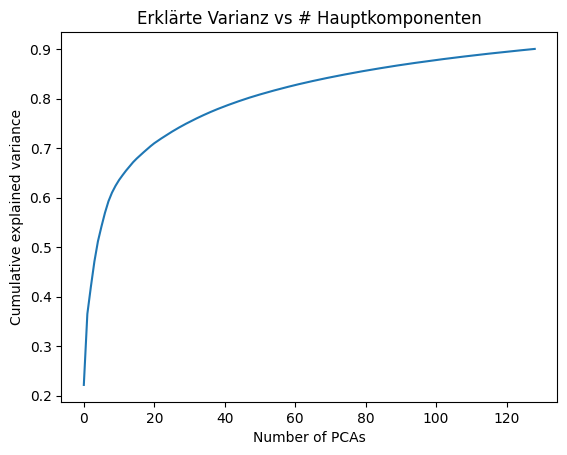

In [25]:
# 3 plot
cumulative_explained_variance = np.cumsum(model.named_steps['pca'].explained_variance_ratio_)
ax = sns.lineplot(y=cumulative_explained_variance, x=range(0, len(cumulative_explained_variance)))
ax.set_xlabel("Number of PCAs")
ax.set_ylabel("Cumulative explained variance")
ax.set_title("Erklärte Varianz vs # Hauptkomponenten")

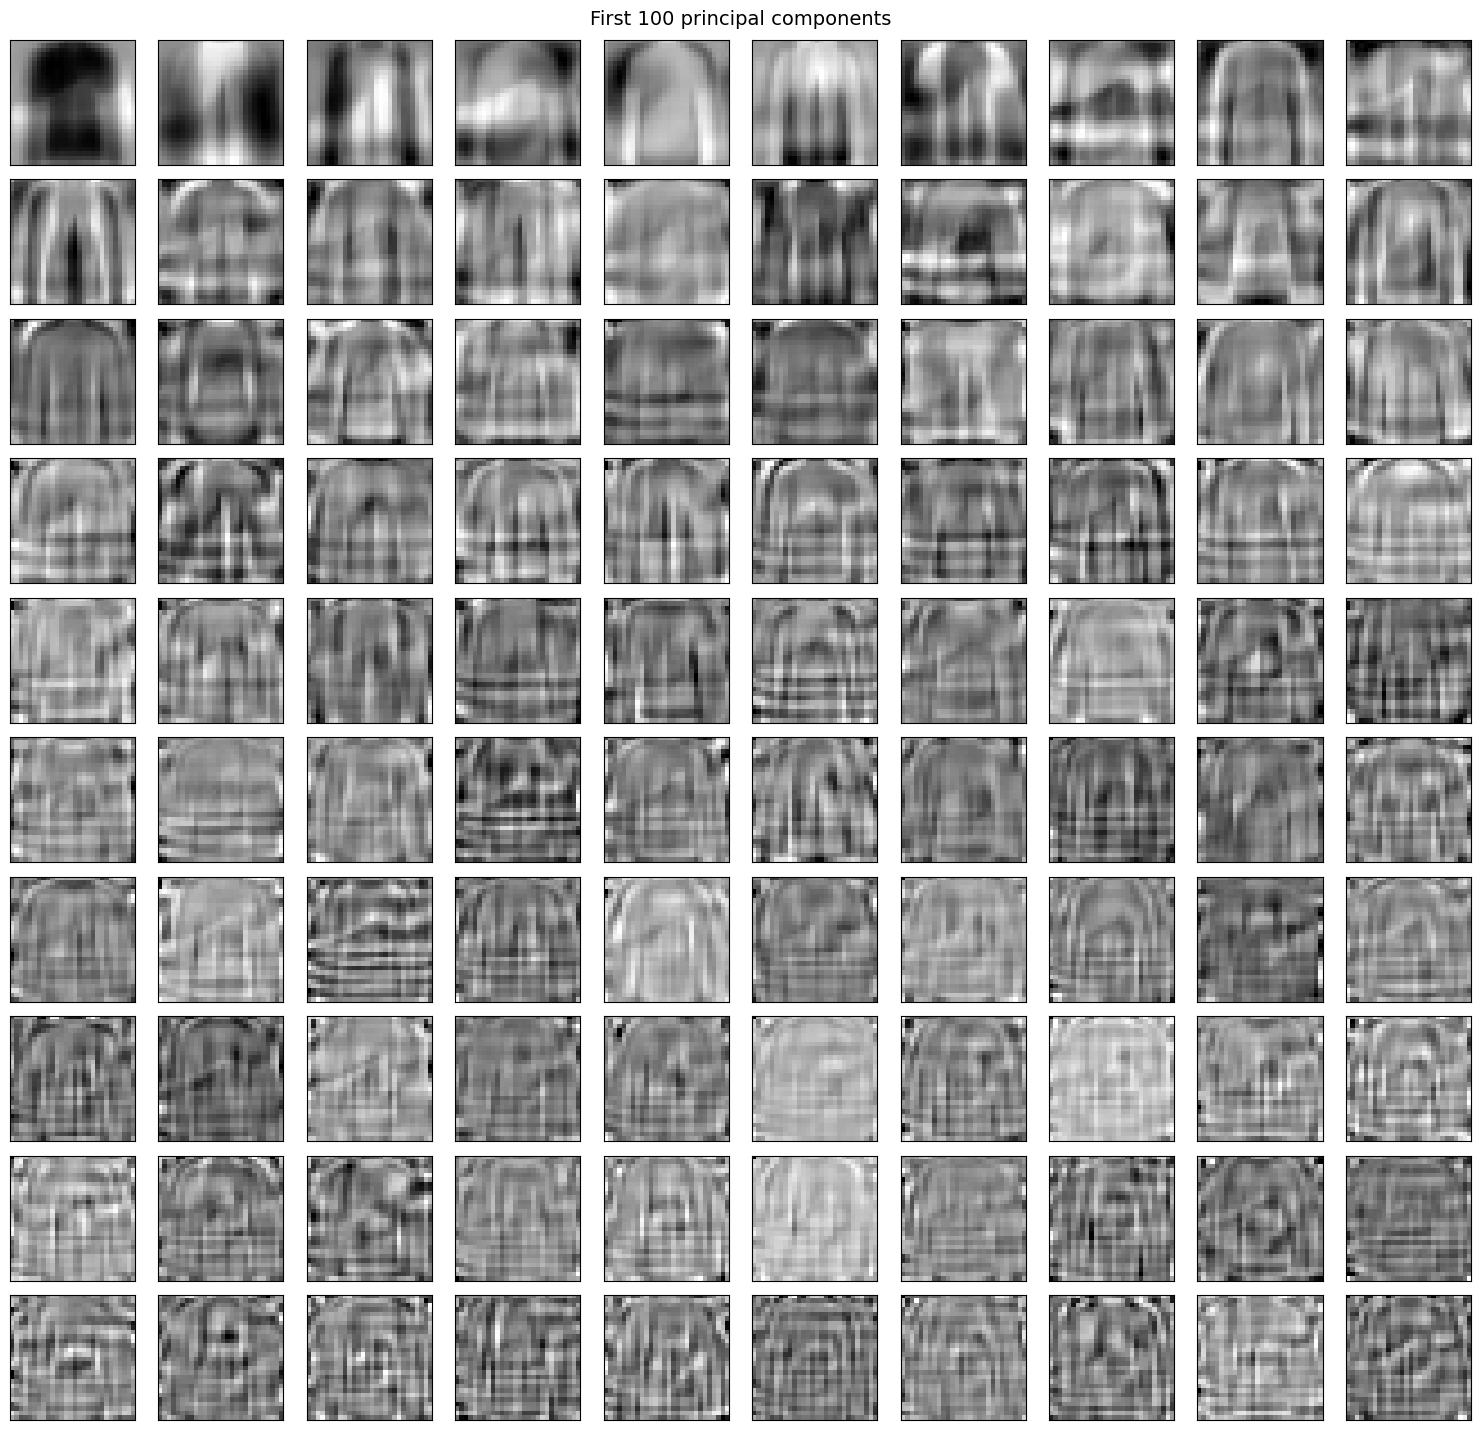

In [26]:
# 4 plot first 100 principal components
plot_image_grid(model.named_steps['pca'].components_[:100], title='First 100 principal components')

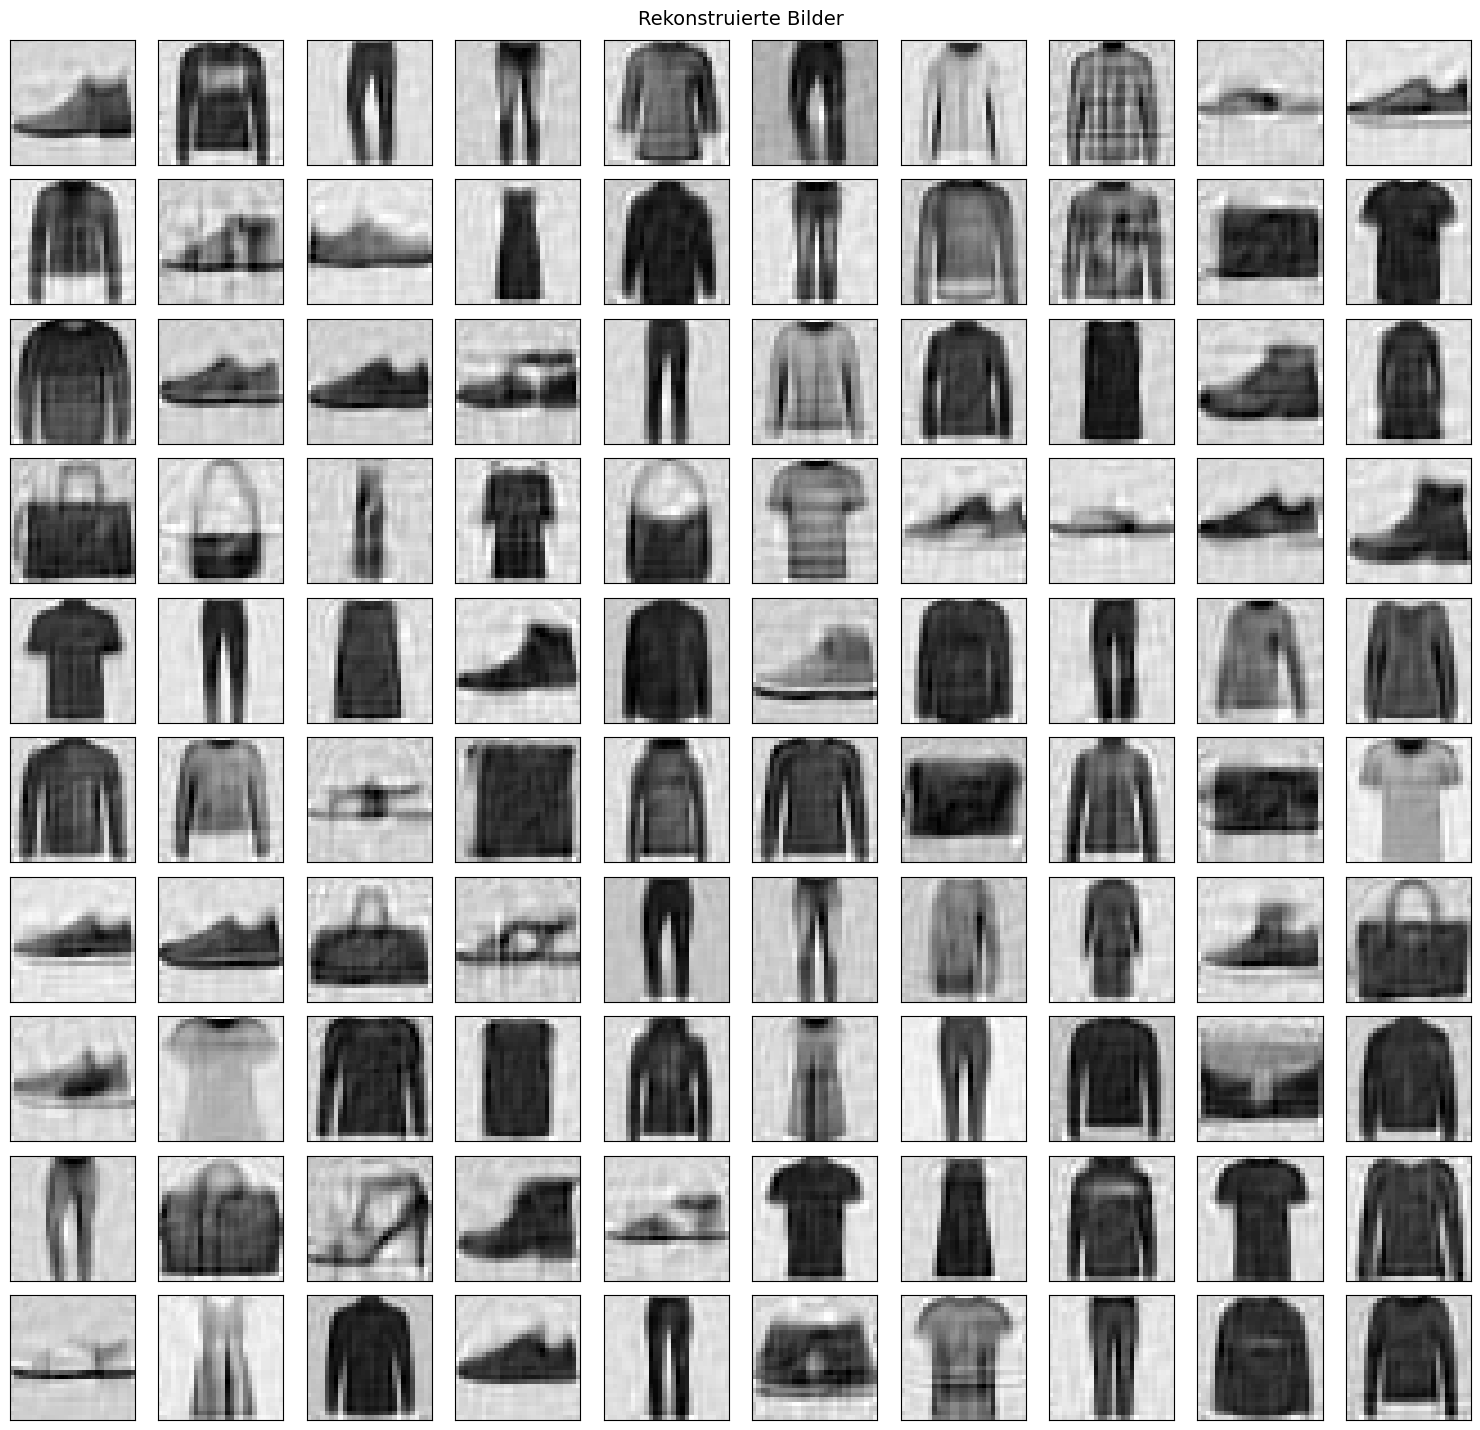

In [27]:

# 5
pca_rekon_images = model.named_steps['pca'].inverse_transform(model.named_steps['pca'].transform(X))
plot_image_grid(pca_rekon_images[:100], title='Rekonstruierte Bilder')

## Aufgabe 2) - Non-Negative Matrix Factorization

Da die Fashion-MNIST Bilder aus rein positiven Pixel-Werten bestehen können wir NMF anwenden. Insbesondere möchten wir:

1. Die Daten-Matrix mit NMF zerlegen. Dazu verwenden / suchen wir k=100 Komponenten. Benutzen Sie `sklearn.decomposition.NMF()`
2. Danach schauen wir uns die Komponenten an (mit `plot_image_grid()`) Überzeugt Sie das Resultat? Wie vergleicht es sich zu den Komponenten aus der PCA? Warum sind diese unterschiedlich?
3. Rekonstruieren Sie die ersten 100 Bilder mit 128 Komponenten. Was halten Sie vom Resultat? Bevorzugen Sie PCA oder NMF?

In [40]:
# use NMF model and fit it
nmf = NMF(init='nndsvda', n_components=128)
x_nmf = nmf.fit_transform(X)

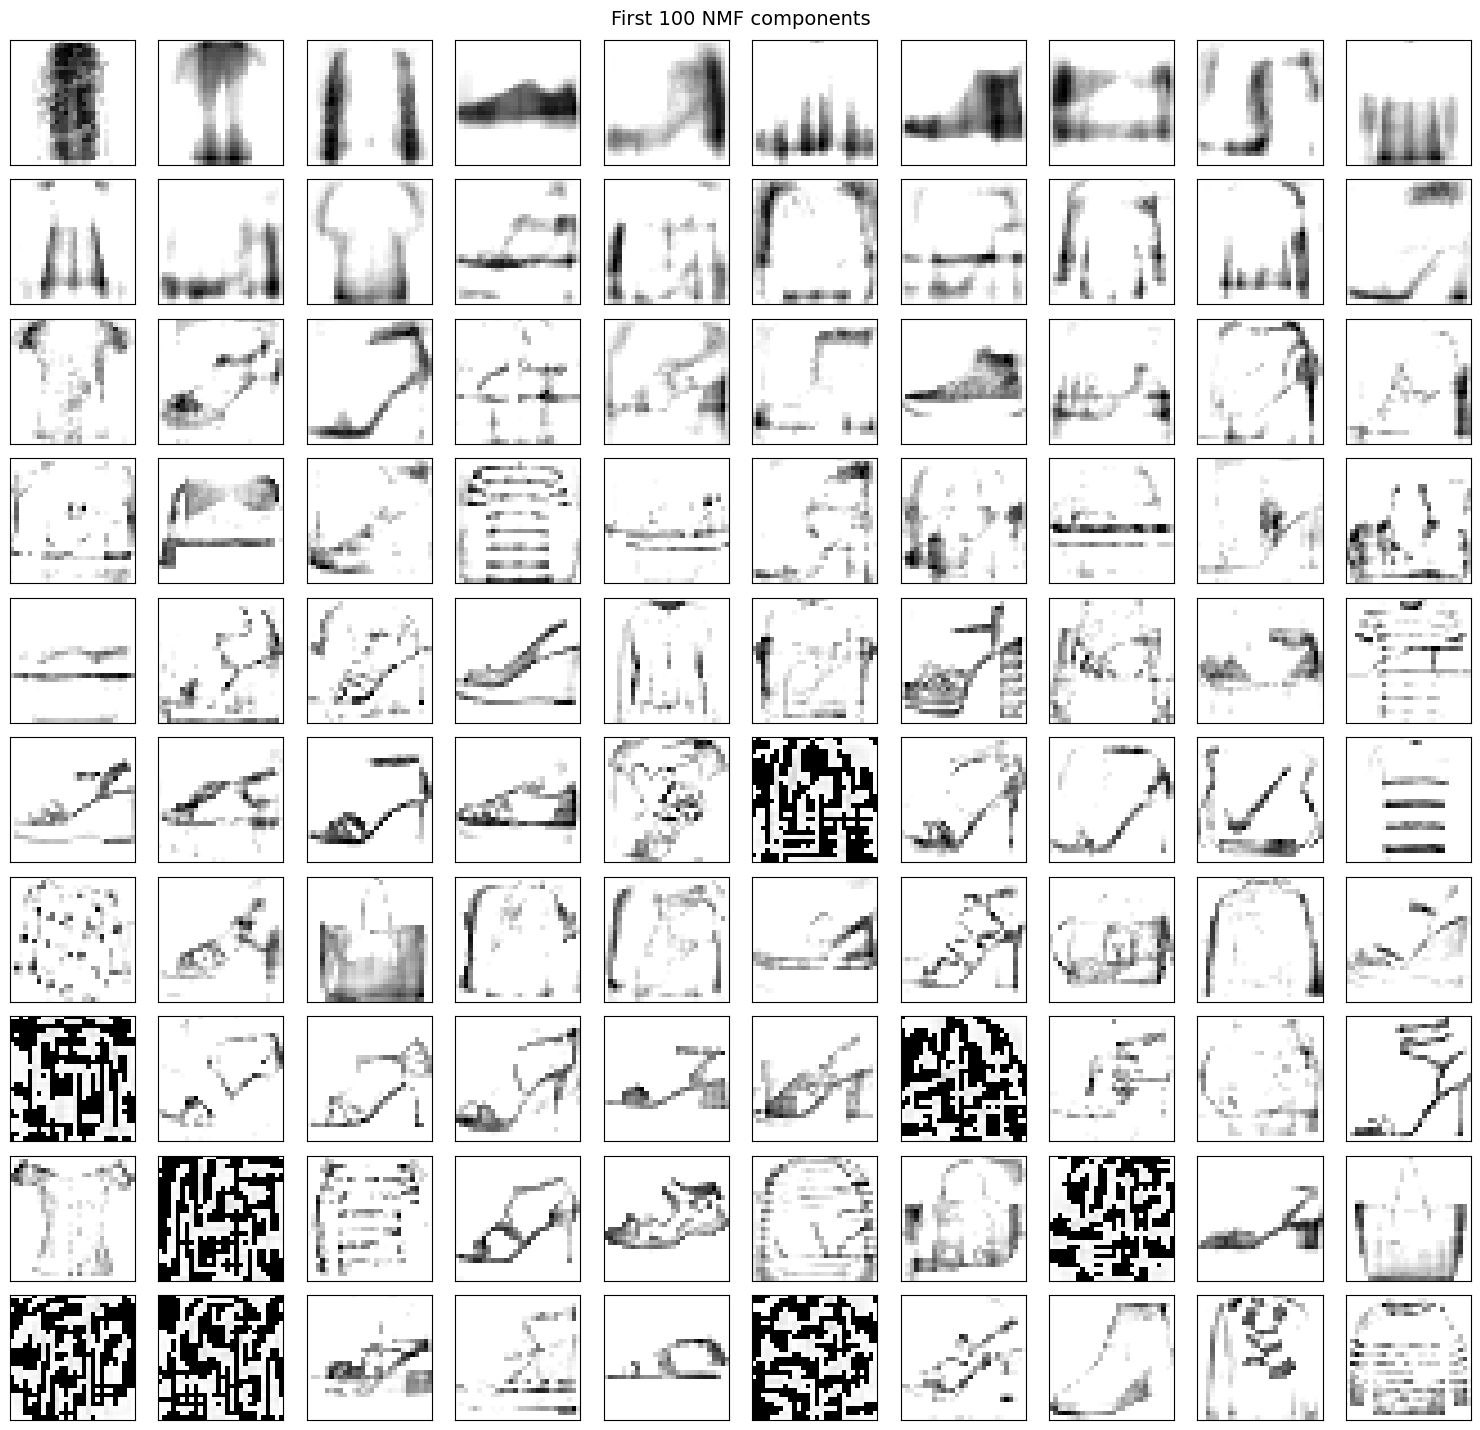

In [41]:
# plot first 100 components
plot_image_grid(nmf.components_[:100], title='First 100 NMF components')


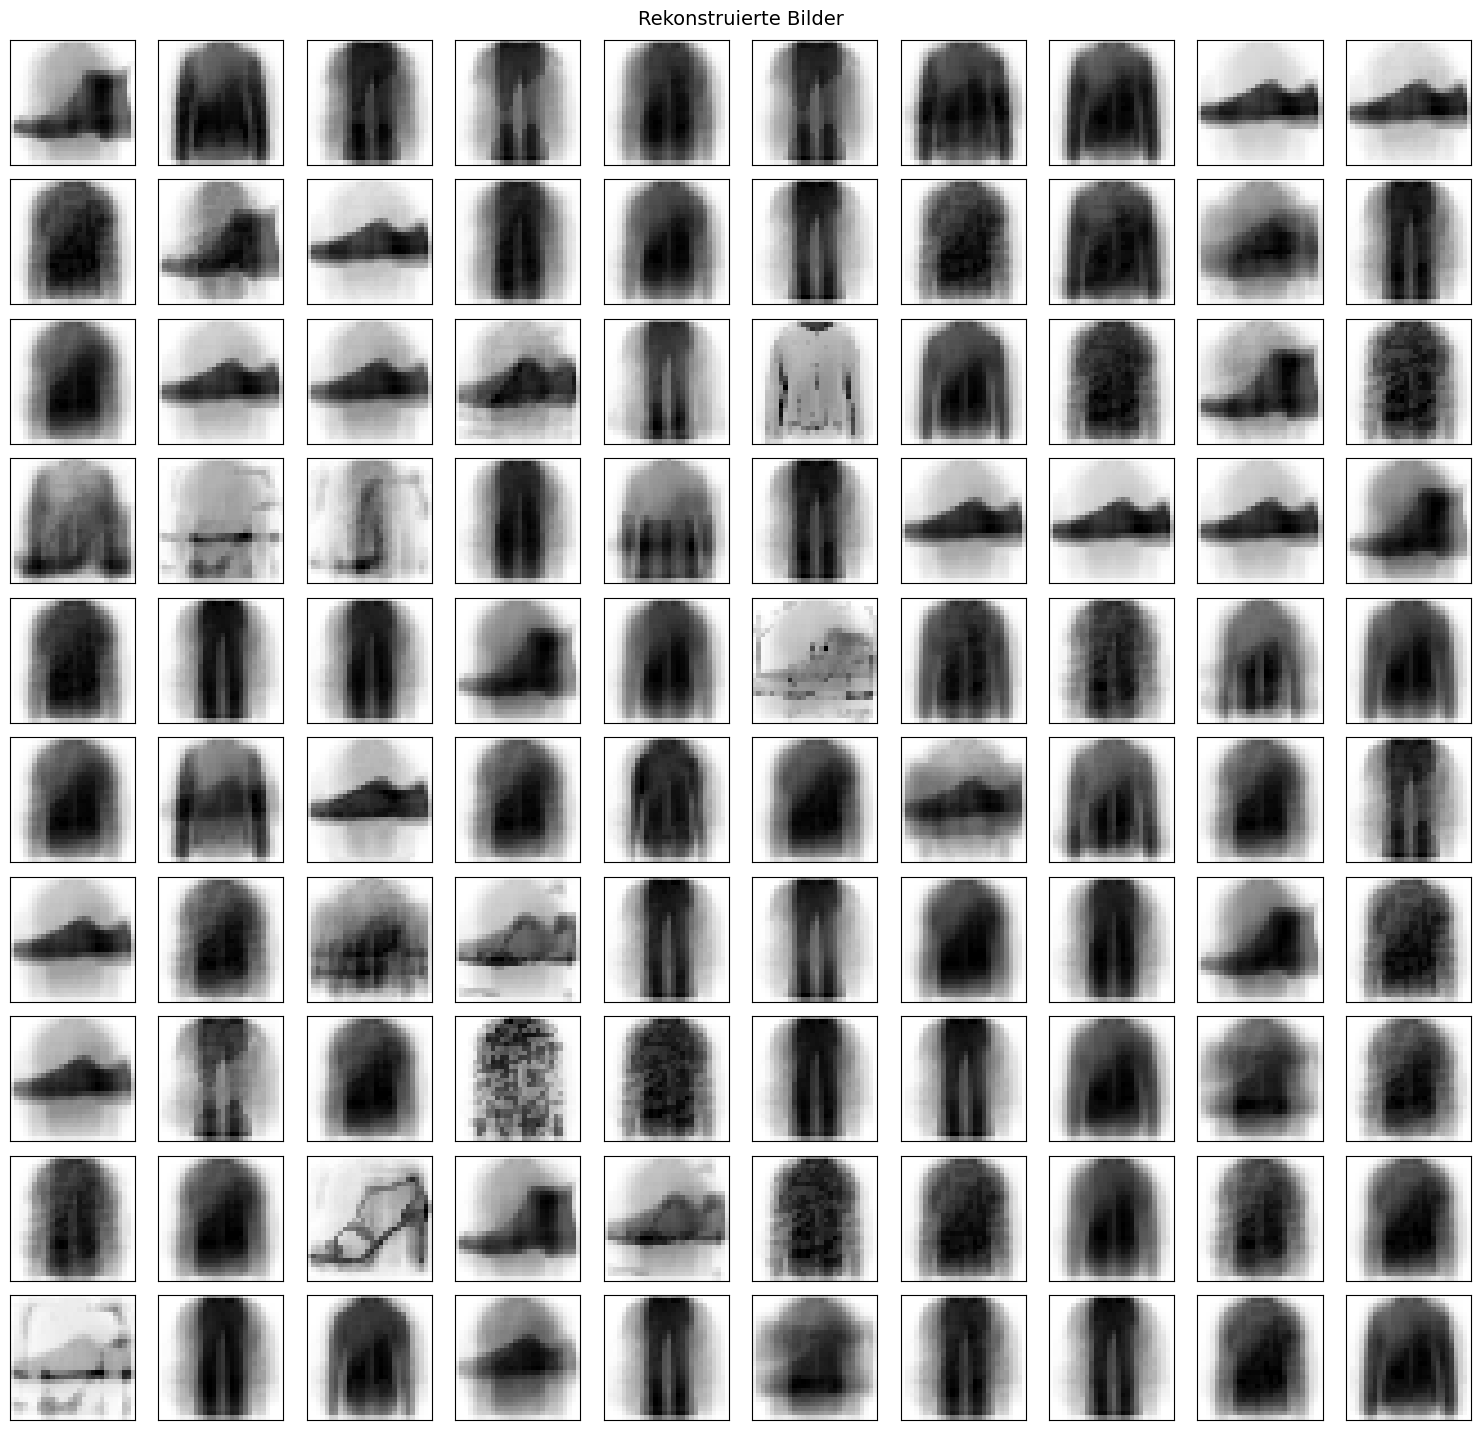

In [43]:
# try to reconstruct the images
nmf_rekon_images = x_nmf.dot(nmf.components_)
plot_image_grid(nmf_rekon_images[:100], title='Rekonstruierte Bilder')

## Aufgabe 3) - K-Means Clustering

Wir möchten nun Gruppen / Klassen identifizieren. Dazu gehen wir folgendermassen vor:

1. Wir Benutzen die Komponenten aus der PCA als Features um ein K-Means Clustering durchzuführen mit `sklearn.cluster.KMeans()`. Clustern Sie für `k` von `1` bis `20` Klassen.
2. Plotte einen Ellbow-Plot um die optimale Anzahl Cluster `k` zu identifizieren. Ist die Antwort eindeutig? Wählen Sie das für Sie beste `k`.
3. Plotte für die gefundenen Klassen jeweils 25 Bilder. Beurteilen Sie das Ergebnis.

In [46]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(X)

pca = PCA()
x_pca = pca.fit_transform(x_scaled)

In [48]:

num_of_clusters = 20
num_of_components = 20
k_mean_results = [KMeans(n_clusters=k).fit(x_pca[:, 0:num_of_components]) for k in range(1, num_of_clusters + 1)]
print(k_mean_results)

[KMeans(n_clusters=1), KMeans(n_clusters=2), KMeans(n_clusters=3), KMeans(n_clusters=4), KMeans(n_clusters=5), KMeans(n_clusters=6), KMeans(n_clusters=7), KMeans(), KMeans(n_clusters=9), KMeans(n_clusters=10), KMeans(n_clusters=11), KMeans(n_clusters=12), KMeans(n_clusters=13), KMeans(n_clusters=14), KMeans(n_clusters=15), KMeans(n_clusters=16), KMeans(n_clusters=17), KMeans(n_clusters=18), KMeans(n_clusters=19), KMeans(n_clusters=20)]


Text(0.5, 1.0, 'Elbow-Plot')

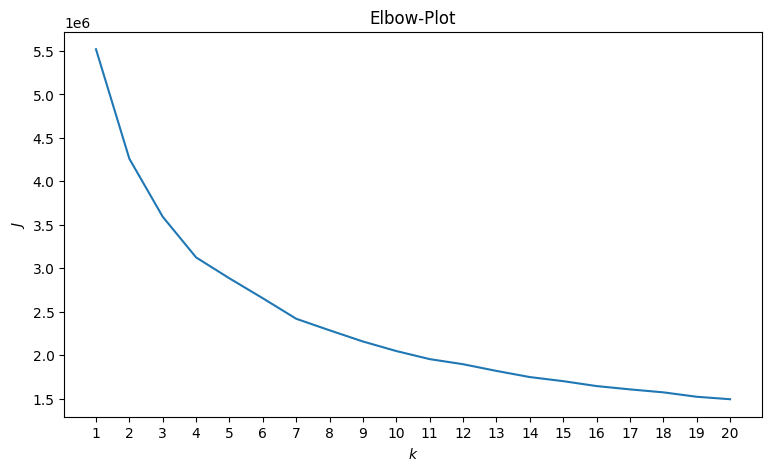

In [49]:
elements = [k.inertia_ for k in k_mean_results]

fix, ax = plt.subplots(figsize=(9, 5))
sns.lineplot(x=range(1, num_of_clusters + 1), y=elements, ax=ax)
ax.set_xticks(np.arange(1,num_of_clusters + 1))
ax.set_xticklabels([str(idx) for idx in range(1, num_of_clusters + 1)])
ax.set_ylabel(r'$J$')
ax.set_xlabel(r'$k$')
ax.set_title('Elbow-Plot')

In [50]:
found_class = 5
kmean = k_mean_results[found_class - 1]

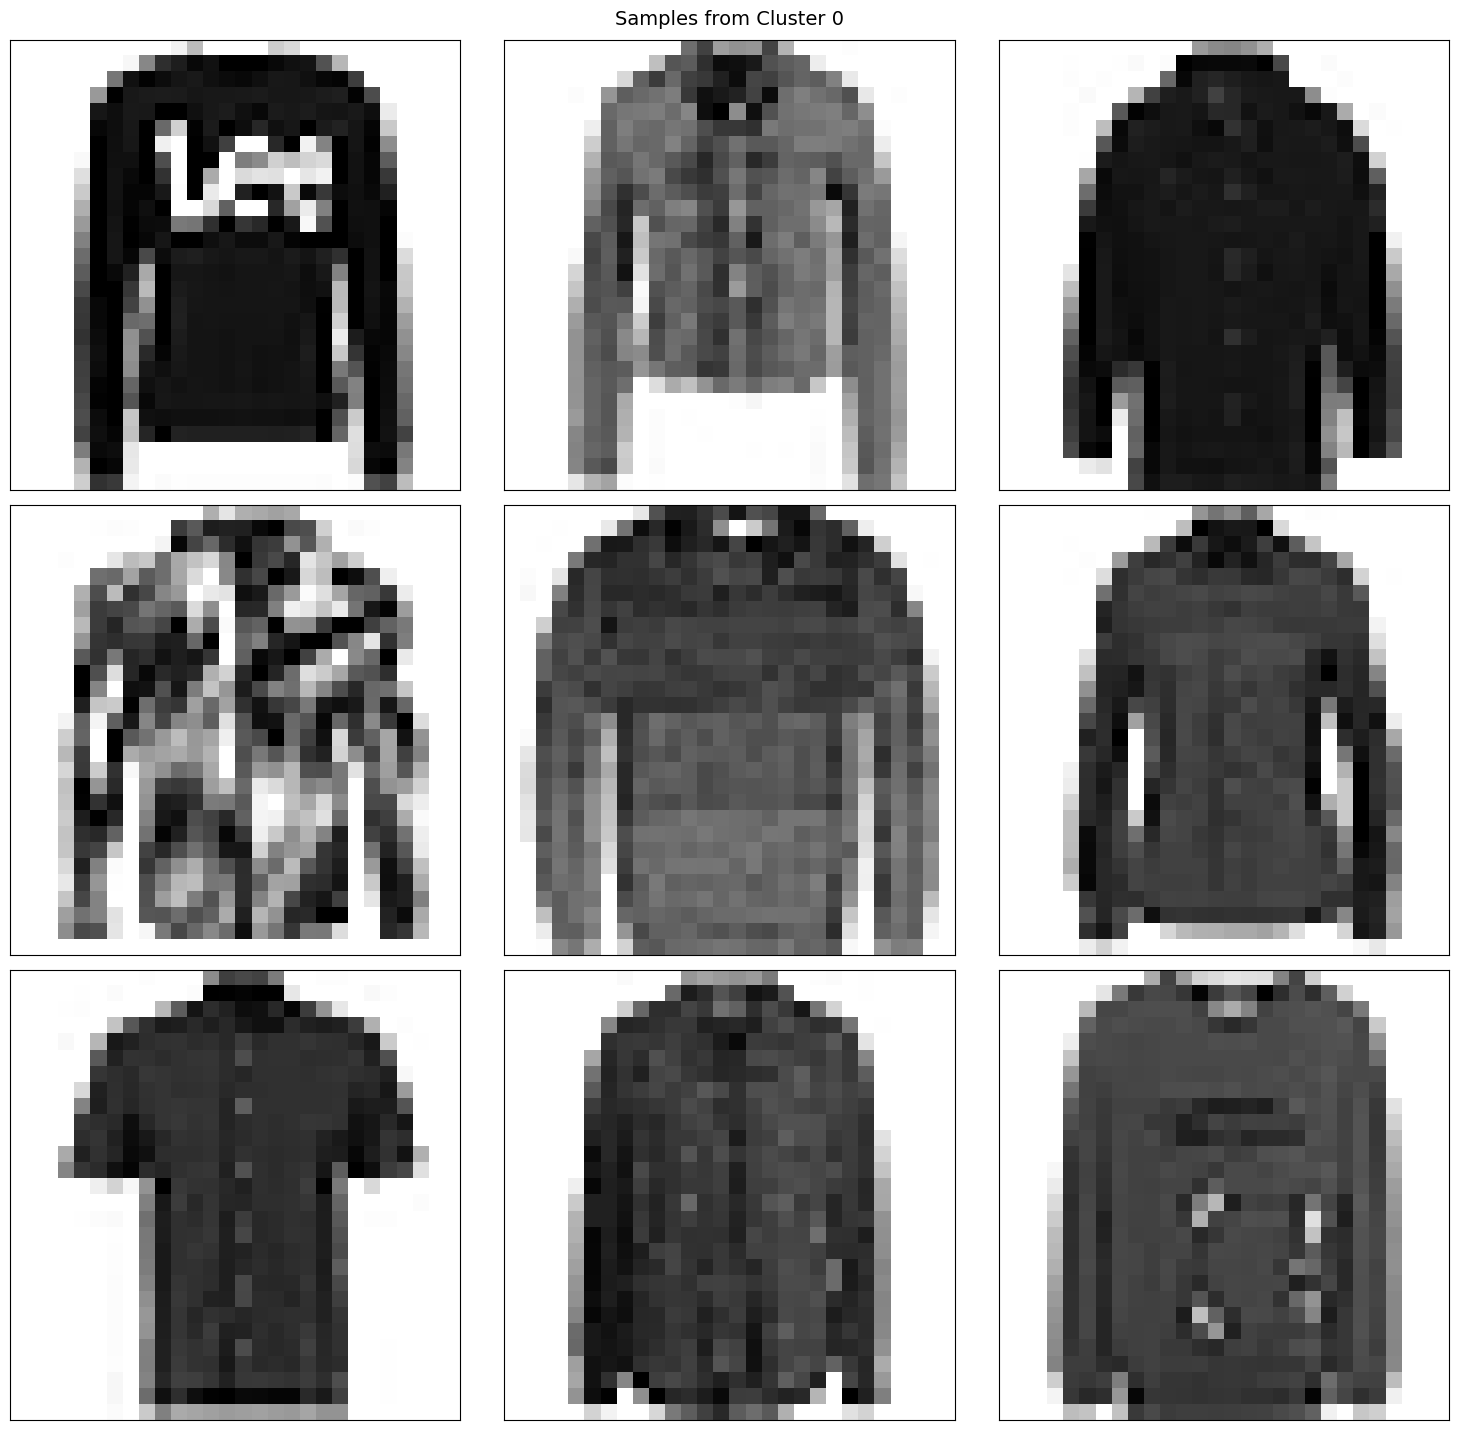

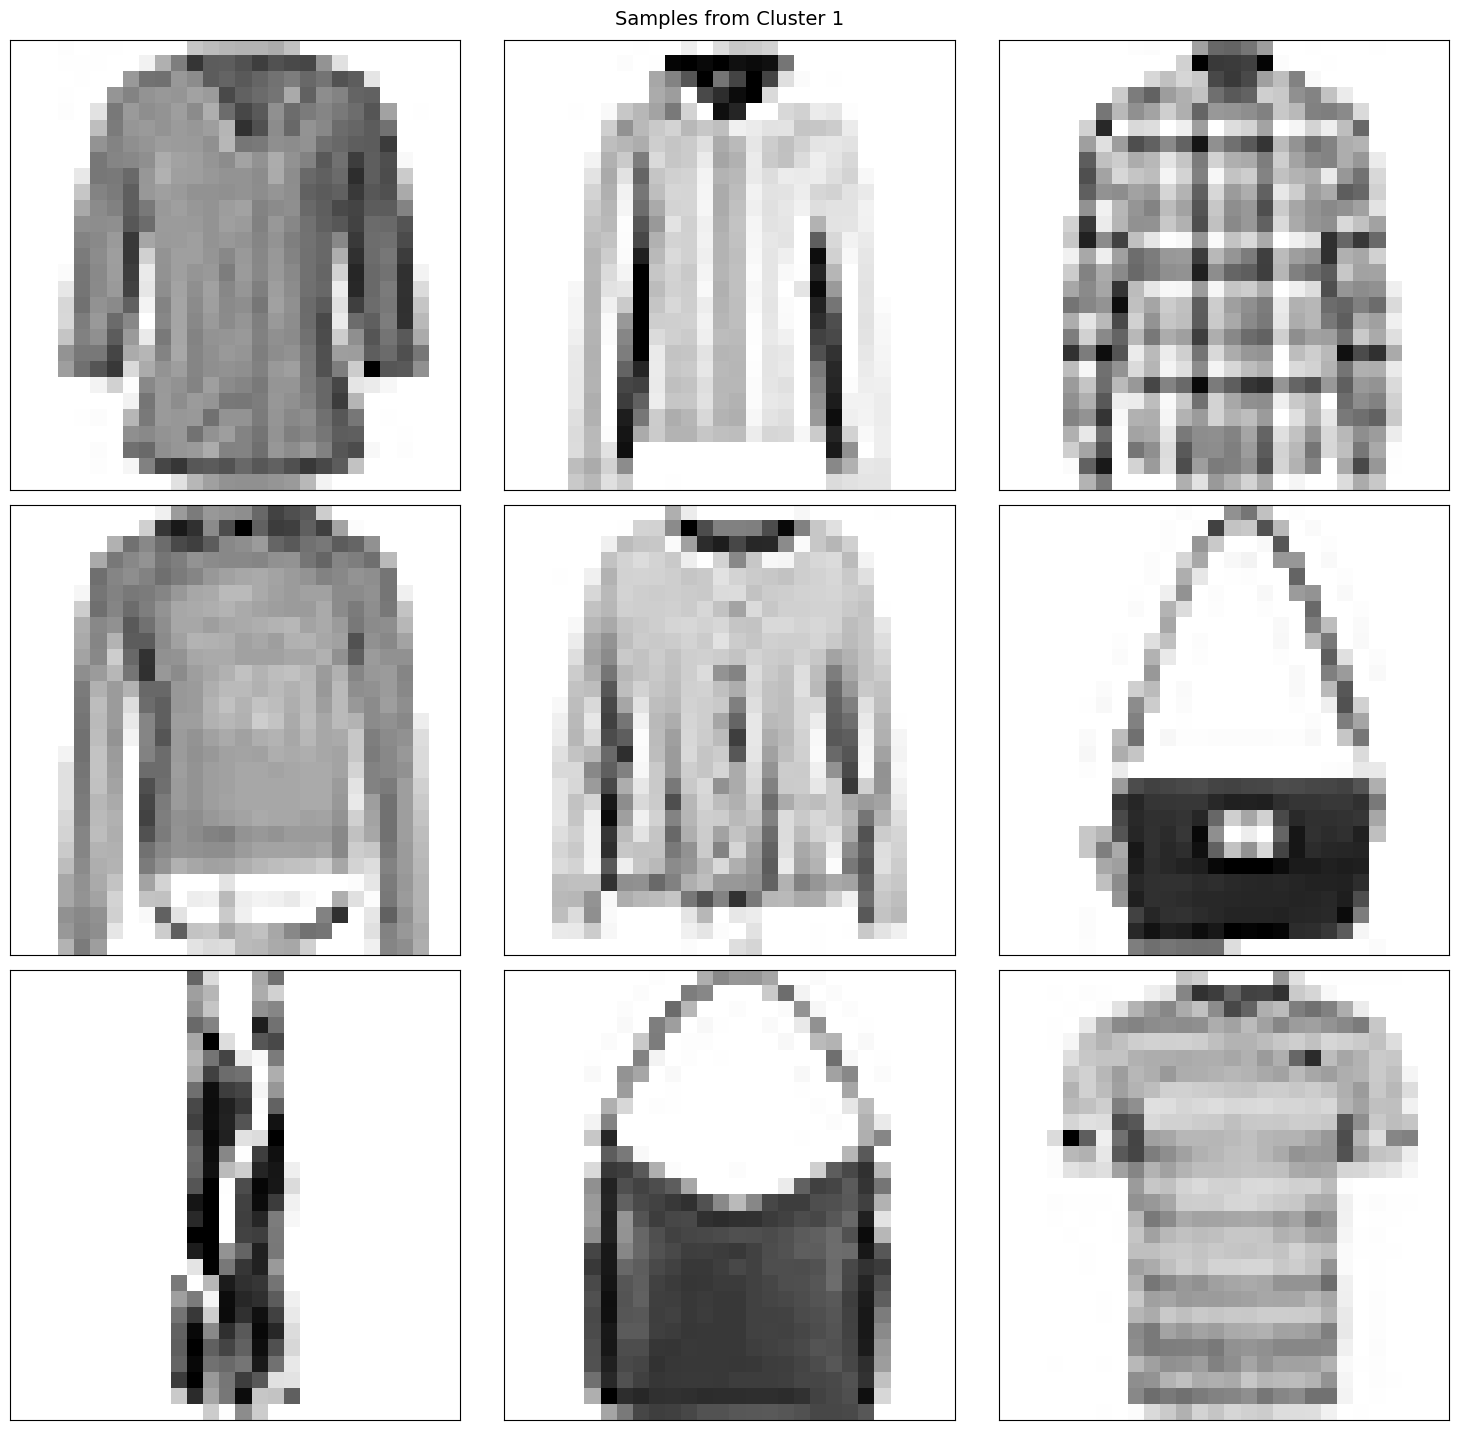

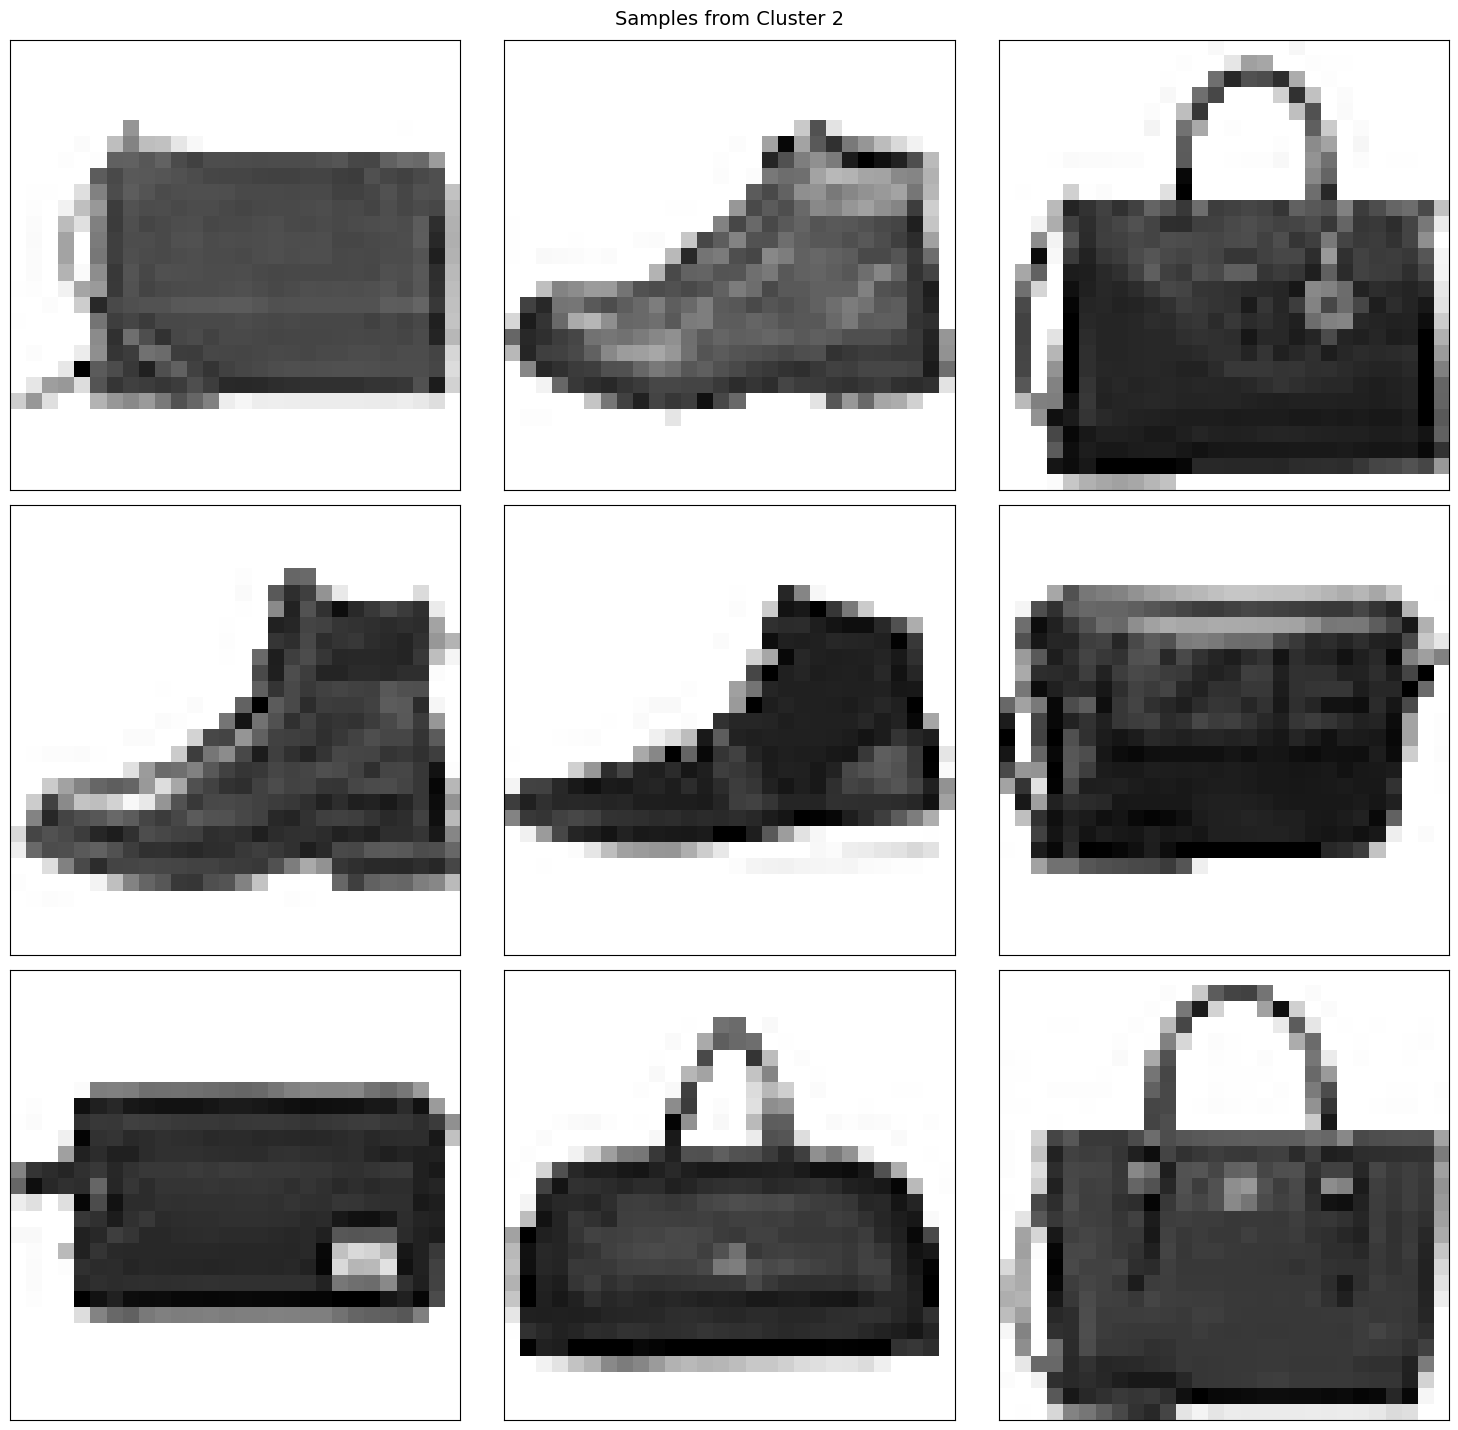

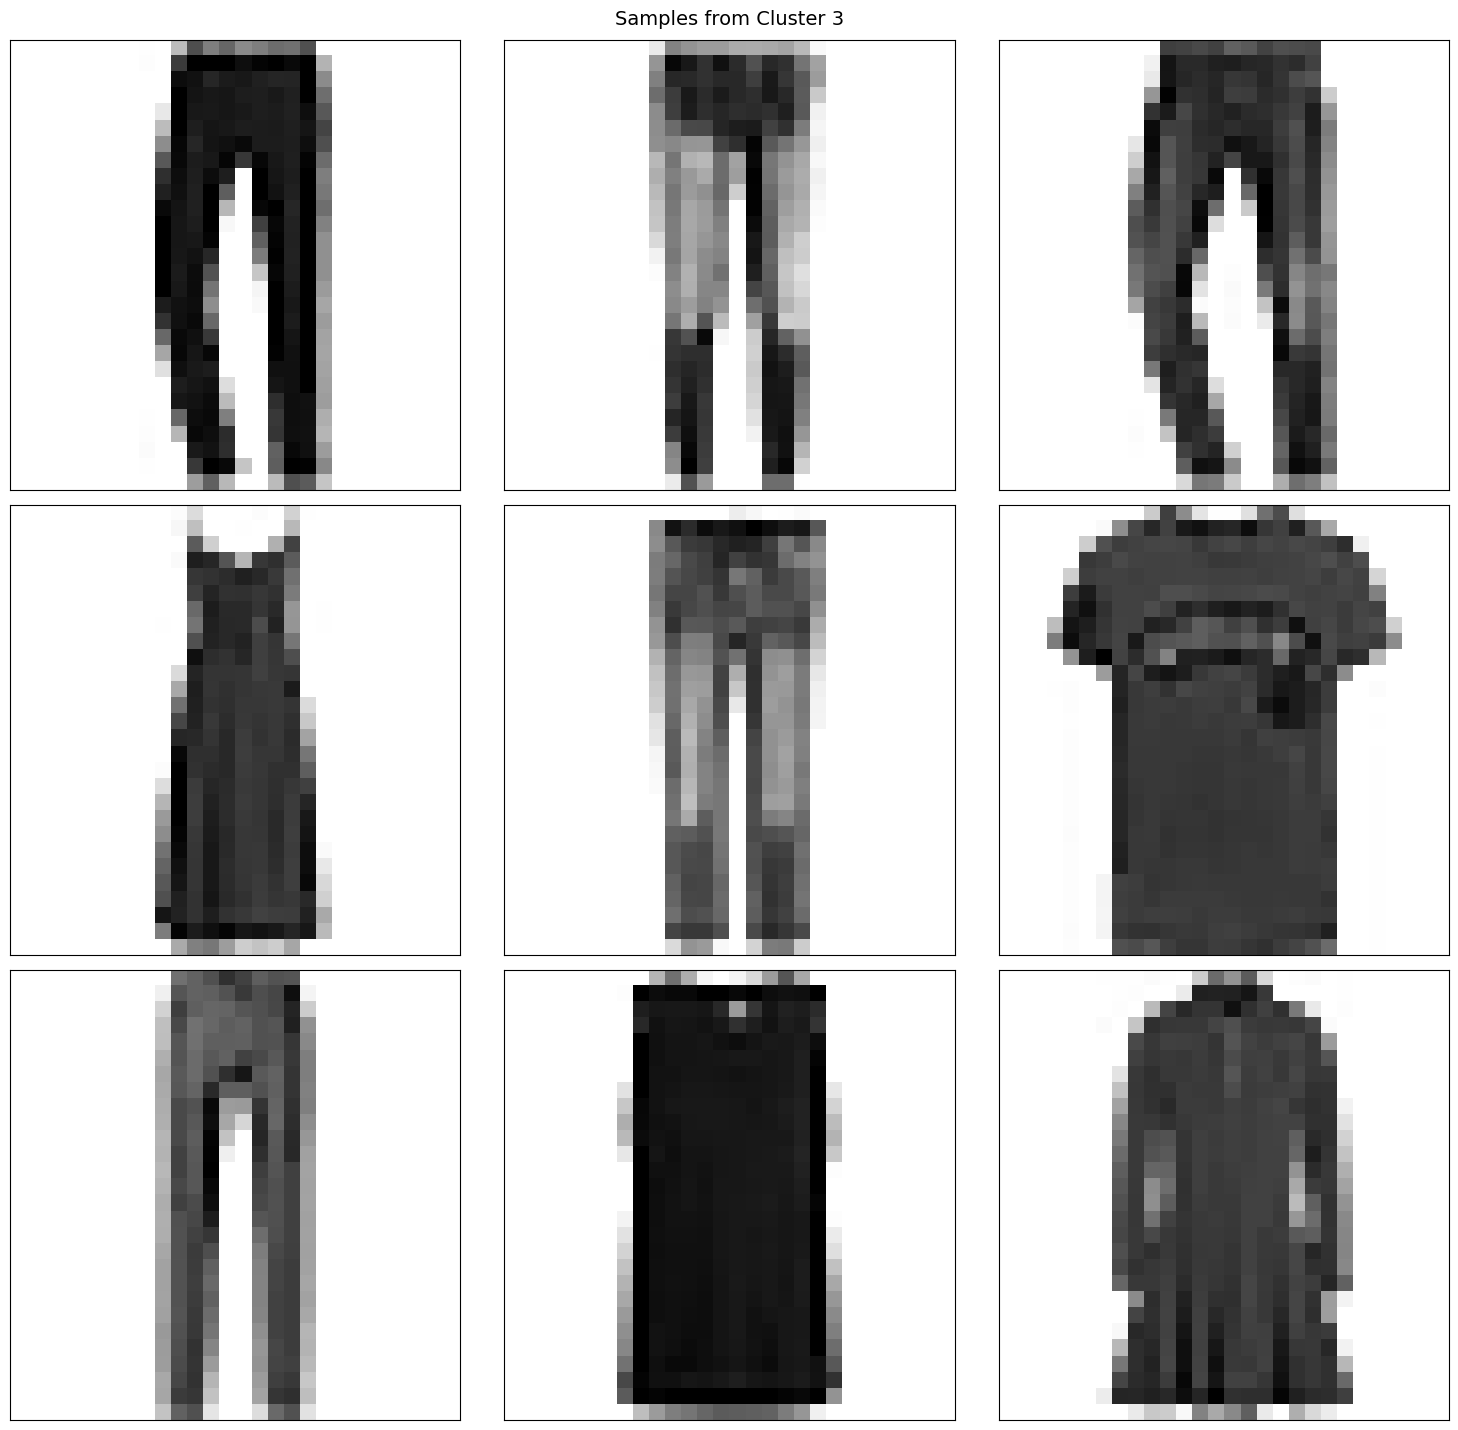

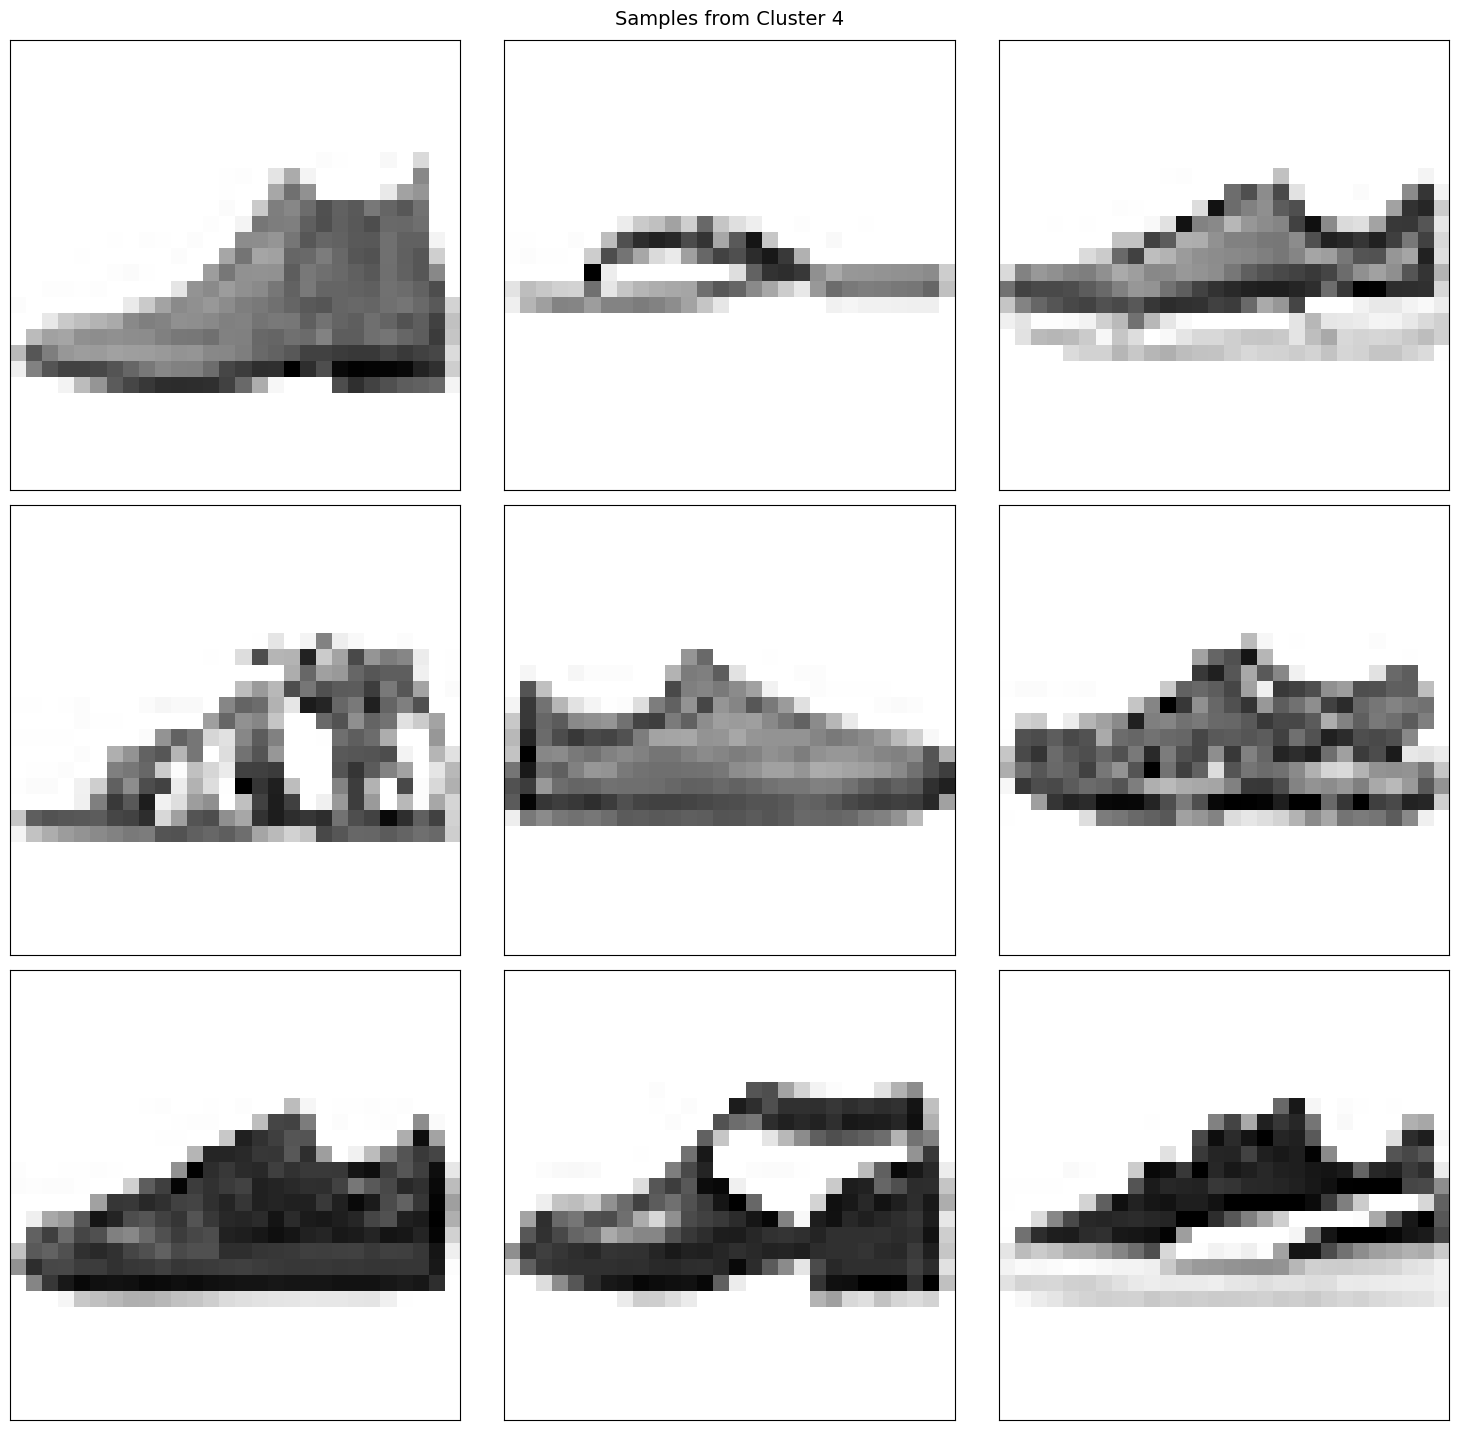

In [52]:
for label in range(0, found_class):
    x_cluster = X[kmean.labels_ == label, :]
    plot_image_grid(x_cluster, N=3, title=f"Samples from Cluster {label}")
    plt.show()